In [22]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
from sklearn import linear_model

In [24]:
def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd:
        data.append(lv)
    header = data[0]
    infectionData=(data[1:])
    infectionData = np.array(infectionData)
    dates = infectionData[:,0]
    dates = dates.tolist()
    infected = infectionData[:,1]
    tested = infectionData[:,2]
    recovered = infectionData[:,3]
    deaths = infectionData[:,4]
    deaths = deaths.astype(np.float)
    recovered = recovered.astype(np.float)
    tested = tested.astype(np.float)
    infected = infected.astype(np.float)
    return dates, infected, tested, recovered, deaths

In [26]:
# Modify the path syntax based on the current platform
if platform.system() == "Windows":
    pathc="..\\Data\\Italian Data\\"
elif platform.system() == "Linux":
    pathc="../Data/Italian Data/"
filename = "National Data.csv"
dates loadData(pathc + filename)



(['2020-02-24T18:00:00',
  '2020-02-25T18:00:00',
  '2020-02-26T18:00:00',
  '2020-02-27T18:00:00',
  '2020-02-28T18:00:00',
  '2020-02-29T17:00:00',
  '2020-03-01T17:00:00',
  '2020-03-02T18:00:00',
  '2020-03-03T18:00:00',
  '2020-03-04T17:00:00',
  '2020-03-05T17:00:00',
  '2020-03-06T17:00:00',
  '2020-03-07T18:00:00',
  '2020-03-08T18:00:00',
  '2020-03-09T18:00:00',
  '2020-03-10T18:00:00',
  '2020-03-11T17:00:00',
  '2020-03-12T17:00:00',
  '2020-03-13T17:00:00',
  '2020-03-14T17:00:00',
  '2020-03-15T17:00:00',
  '2020-03-16T17:00:00',
  '2020-03-17T17:00:00',
  '2020-03-18T17:00:00',
  '2020-03-19T17:00:00',
  '2020-03-20T17:00:00',
  '2020-03-21T17:00:00',
  '2020-03-22T17:00:00',
  '2020-03-23T17:00:00',
  '2020-03-24T17:00:00',
  '2020-03-25T17:00:00',
  '2020-03-26T17:00:00',
  '2020-03-27T17:00:00',
  '2020-03-28T17:00:00',
  '2020-03-29T17:00:00',
  '2020-03-30T17:00:00',
  '2020-03-31T17:00:00',
  '2020-04-01T17:00:00',
  '2020-04-02T17:00:00',
  '2020-04-03T17:00:00',


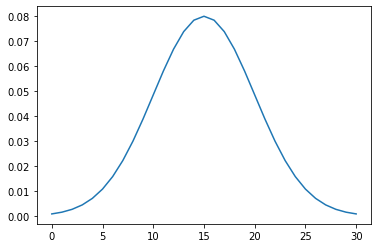

In [4]:
sigma = 5
conSize = 15
x2 = np.arange(-conSize, 1 + conSize)
kernel2 = np.exp(-(x2) ** 2 / (2 * sigma ** 2))
kernel2=kernel2/sum(kernel2)
plt.plot(kernel2)

450


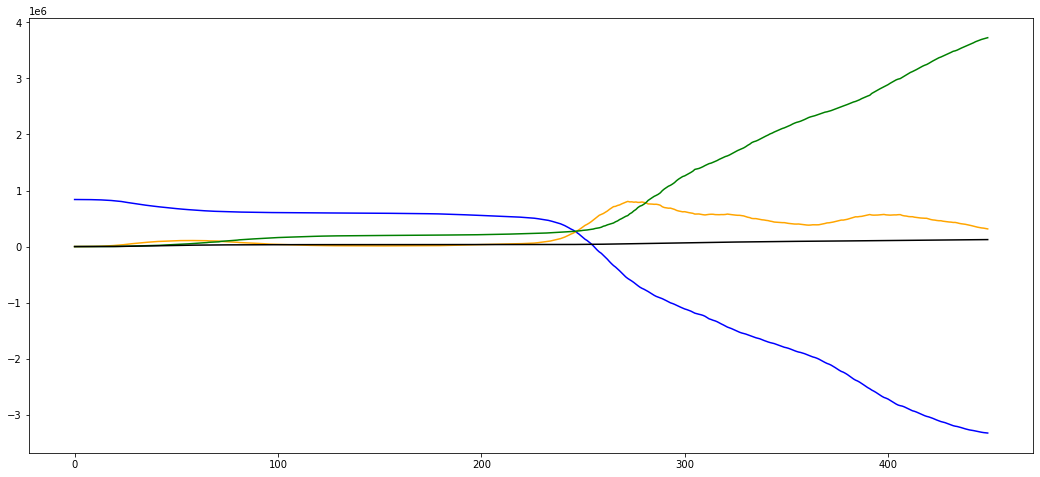

In [5]:
CountyD=database.CovidData
[N] = np.shape(CountyD[13].positive)
print(N)

popITA = 60000000

infectRaw = [0] * N
recovRaw = [0] * N
deadRaw = [0] * N
natTested = [0] * N
for key in CountyD:
    natTested += CountyD[key].tested
    #infectRaw += CountyD[key].totalCases
    infectRaw += CountyD[key].positive
    recovRaw += CountyD[key].healed
    deadRaw += CountyD[key].deaths

q = .014
#since S+I+R+D always equals the same constant S(t) can now be determined
susceptRaw = q*popITA - infectRaw - recovRaw - deadRaw

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(susceptRaw, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
#ax.plot(natTested, color = 'red', label = 'tested') #graphing tested makes the scaling hard to visualize
ax.plot(infectRaw, color='orange', label='infected')
ax.plot(recovRaw, color='green', label='recovered')
ax.plot(deadRaw, color='black', label='dead')

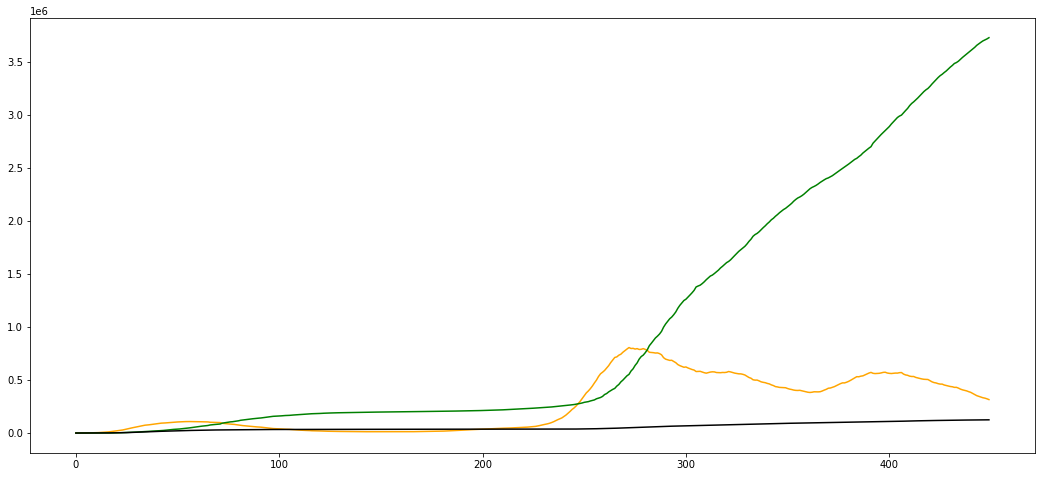

In [6]:
#option for use of raw numbers for data, no smoothing
infect = infectRaw
recov = recovRaw
dead = deadRaw
suscept = susceptRaw

#convolve the data to smooth out, valid mode keeps bound points realistic
#infect = np.convolve(infectRaw, kernel2, 'valid')
#recov = np.convolve(recovRaw, kernel2, 'valid')
#dead = np.convolve(deadRaw, kernel2, 'valid')
#suscept = popITA - infect - recov - dead #S + I + R + D = totalPop

fig, ax = plt.subplots(figsize=(18,8))
#ax.plot(suscept, color='blue', label='suscpetible') #graphing susceptible makes the scaling to hard to visualize
ax.plot(infect, color='orange', label='infected')
ax.plot(recov, color='green', label='recovered')
ax.plot(dead, color='black', label='dead')

### Modeling $\gamma$ (recovery rate), $\beta$ (transmission rate), and $\upsilon$ (death rate).

$S(t+1) = -\beta \frac{S(t)I(t)}{S(t)+I(t)} + S(t)$

$I(t+1) = \beta \frac{S(t)I(t)}{S(t)+I(t)} - \gamma I(t) - \upsilon I(t) + I(t)$

$R(t+1) = \gamma I(t) + R(t)$

$D(t+1) = \upsilon I(t) + D(t)$

### As a matrix

$\begin{bmatrix}
S(t+1) \\ I(t+1) \\ R(t+1) \\ D(t+1)
\end{bmatrix}
=
\begin{bmatrix}
S(t) & -\frac{S(t)I(t)}{S(t)+I(t)} & 0 & 0 \\
I(t) & \frac{S(t)I(t)}{S(t)+I(t)} & -I(t) & -I(t) \\
R(t) & 0 & I(t) & 0 \\
D(t) & 0 & 0 & I(t)
\end{bmatrix}
\begin{bmatrix}
1 \\ \beta \\ \gamma \\ \upsilon
\end{bmatrix}$

In [7]:
sirdMatrix = np.zeros((len(recov) - 1, 4, 4))
nextIterMatrix = np.zeros((len(recov) - 1, 4, 1)) #the S(t+1), I(t+1), ... matrix

#populate the 4x4 matrix with parameters (see above note)
sirdMatrix[:,0,0] = suscept[0:-1]
sirdMatrix[:,0,1] = -(suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])

sirdMatrix[:,1,0] = infect[0:-1]
sirdMatrix[:,1,1] = (suscept[0:-1] * infect[0:-1]) / (suscept[0:-1] + infect[0:-1])
sirdMatrix[:,1,2] = -infect[0:-1]
sirdMatrix[:,1,3] = -infect[0:-1]

sirdMatrix[:,2,0] = recov[0:-1]
sirdMatrix[:,2,2] = infect[0:-1]

sirdMatrix[:,3,0] = dead[0:-1]
sirdMatrix[:,3,3] = infect[0:-1]

#populate the S(t+1), I(t+1), ... matrix
nextIterMatrix[:,0,0] = suscept[1:]
nextIterMatrix[:,1,0] = infect[1:]
nextIterMatrix[:,2,0] = recov[1:]
nextIterMatrix[:,3,0] = dead[1:]

clf = linear_model.Lasso(alpha=10)
clf.fit(sirdMatrix, nextIterMatrix)
coef = clf.coef_
paramMatrix = np.linalg.solve(sirdMatrix, nextIterMatrix) #solve Ax = B, where A = sirdMatrix, and B = nextIterMatrix

#copy params over from the solved matrix
transRate = paramMatrix[:,1,0] #beta
recovRate = paramMatrix[:,2,0] #gamma
deathRate = paramMatrix[:,3,0] #upsilon

#plot rates over time
fig, ax = plt.subplots(3, 1, figsize=(18,8))
ax[0].plot(transRate, color='orange', label='Transmission Rate')
ax[1].plot(recovRate, color='green', label='Recovery Rate')
ax[2].plot(deathRate, color='black', label='Death Rate')

ValueError: Found array with dim 3. Estimator expected <= 2.

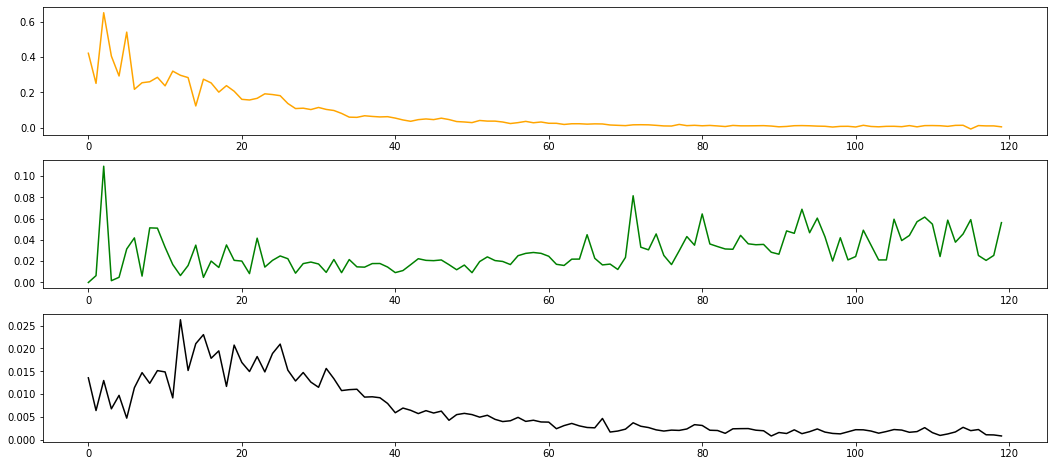

In [178]:
transRateSect = transRate[0:120]
recovRateSect = recovRate[0:120]
deathRateSect = deathRate[0:120]


#graph only the first 120 days
fig, ax = plt.subplots(3, 1, figsize=(18,8))
ax[0].plot(transRateSect, color='orange', label='Transmission Rate')
ax[1].plot(recovRateSect, color='green', label='Recovery Rate')
ax[2].plot(deathRateSect, color='black', label='Death Rate')

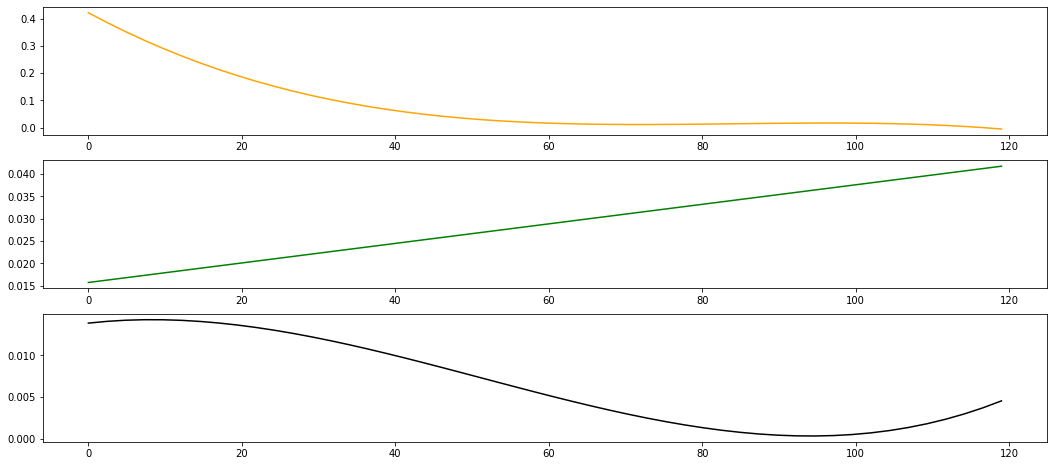

In [179]:
fig, ax = plt.subplots(3, 1, figsize=(18,8))

x=range(0, len(transRateSect))
xPlot = np.linspace(x[0], x[-1])

poly = np.poly1d(np.polyfit(x, transRateSect, 3))
yPlot = poly(xPlot)
ax[0].plot(xPlot, yPlot, color='orange', label='Transmission Rate')

poly = np.poly1d(np.polyfit(x, recovRateSect, 1))
yPlot = poly(xPlot)
ax[1].plot(xPlot, yPlot, color='green', label='Recovery Rate')

poly = np.poly1d(np.polyfit(x, deathRateSect, 3))
yPlot = poly(xPlot)
ax[2].plot(xPlot, yPlot, color='black', label='Death Rate')